Script to plot the reflection, transmission and absorption of a twisted polaritonic crystal (PC) on an in-plane anisotropic material (MoO3 as example). The derivations are based on thin layer approximation.

# Open the packages for the script

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
import math 

In [3]:
# Define some useful functions for the code
cos = np.cos
sin = np.sin
pi = np.pi
exp = np.exp
sqrt = np.sqrt
bessel = spec.jv

## Define the function of the permittivity of MoO3
Parameters from paper: https://onlinelibrary.wiley.com/doi/abs/10.1002/adma.201908176

In [4]:
def eps_harm_Osc(w, wT, wL, gamma):
    eps_h = (w*w-wL**2+1j*gamma*w)/(w*w-wT**2+1j*gamma*w)
    return eps_h

In [5]:
def eps_MoO3(w, axis):
    if(axis=='[100]'): # x-axis of MoO3
        epsinf = 6.09
        gamma = np.array([[73, 11.9, 2.1]])
        wTO = np.array([[507, 822.7, 998.8]])
        wLO = np.array([[534, 978.8, 999.5]])

    if(axis=='[001]'): # z-axis of MoO3
        epsinf = 6.38
        gamma = np.array([[17.9]])
        wTO = np.array([[544.9]])
        wLO = np.array([[855.8]])

    if(axis=='[010]'): # y-axis of MoO3
        epsinf = 4.4
        gamma = np.array([[0.7]])
        wTO = np.array([[963]])
        wLO = np.array([[1006.6]])

    eps = np.ones(np.shape(w)[0],)
    for i in range(np.shape(wTO)[1]):
        eps = eps*eps_harm_Osc(w,wTO[0,i],wLO[0,i],gamma[0,i])

    eps = epsinf*eps

    return eps

# Define functions to run the script

Define functions to index the modes

In [6]:
def  from_real_to_computer(n1,n2):
    # Function to change from real indexes to computer indexes
    # Outputs:
    # from_r_c: translates real indexes into computer indexes
    # from_c_r: translates computer indexes into real indexes

    index = 0
    Ln1 = len(n1)
    Ln2 = len(n2)
    from_r_c = np.zeros((Ln1,Ln2,2))
    from_c_r = np.zeros((Ln1*Ln2*2,3))
    for i in range(Ln1):
        for j in range (Ln2):
            for sigma in range(2):
                from_r_c[i,j,sigma] = index
                from_c_r[index,0] = n1[i]
                from_c_r[index,1] = n2[j]
                from_c_r[index,2] = sigma
                index = index+1

    return from_r_c, from_c_r

In [7]:
def  from_real_to_computerk(n1,n2):
    # Function to change from real indexes to computer indexes
    # Outputs:
    # from_r_c: translates real indexes into computer indexes
    # from_c_r: translates computer indexes into real indexes

    index = 0
    Ln1 = len(n1)
    Ln2 = len(n2)
    from_r_ck = np.zeros((Ln1,Ln2))
    from_c_rk = np.zeros((Ln1*Ln2,2))
    for i in range(Ln1):
        for j in range (Ln2):
            from_r_ck[i,j] = index
            from_c_rk[index,0] = n1[i]
            from_c_rk[index,1] = n2[j]
            index = index+1

    return from_r_ck, from_c_rk

In [8]:
def  from_r_to_c_holes(direcc,nh):
    # Function to change from real indexes to computer indexes
    # Outputs:
    # from_r_c: translates real indexes into computer indexes
    # from_c_r: translates computer indexes into real indexes

    index = 0
    Lnh = len(nh)
    from_r_c_h = np.zeros((Lnh,direcc))
    from_c_r_h = np.zeros((direcc*Lnh,2))
    for i in range(Lnh):
        for j in range (direcc):
            from_r_c_h[i,j] = index
            from_c_r_h[index,0] = nh[i]
            from_c_r_h[index,1] = j
            index = index+1

    return from_r_c_h, from_c_r_h

Define function to determine the ordinary and extraordinary eigenvectors

In [9]:
def ordinary_extraordinary_modes(qx,qy,ex,ey,ez,q1,q2):
    # Function to select the momentum of extraordinary and ordinary modes

    TOL = 10e-2

    if np.abs(np.real(q1-q2))<10e-4 and np.abs(np.imag(q1-q2))<10e-4: #For the case in which they are equal
        qzo = q1
        qze = q2

    elif np.abs(qx**2)<TOL and np.abs(qy**2)<TOL:
        # Calculations of the deltas for q1 and q2
    
        # Deltas
        delta1x = ex-qy**2-q1**2
        delta1y = ey-qx**2-q1**2
        deltaz = ez-qx**2-qy**2
        delta2x = ex-qy**2-q2**2
        delta2y = ey-qx**2-q2**2

        # M(q1) matrix
        M1=np.zeros((3,3))+0j
        M1[0,:] = [delta1x,qx*qy,qx*q1]
        M1[1,:] = [qx*qy,delta1y,qy*q1]
        M1[2,:] = [qx*q1,qy*q1,deltaz]
    
        Z1 = np.linalg.det(M1)

        # M(q2) matrix
        M2 = np.zeros((3,3))+0j
        M2[0,:] = [delta2x,qx*qy,qx*q2]
        M2[1,:] = [qx*qy,delta2y,qy*q2]
        M2[2,:] = [qx*q2,qy*q2,deltaz]
    
        Z2 = np.linalg.det(M2)

        # delta1 and delta2 for both possibilities, q1 and q2
        delta1_1 = (delta1x-qx**2)/(deltaz*delta1x-qx**2*q1**2)
        delta1_2 = (delta1x-qx**2)/(deltaz*delta2x-qx**2*q2**2)
        delta2_1 = (delta1x*delta1y-qx**2*qy**2)/(delta1x-qx**2)
        delta2_2 = (delta2x*delta2y-qx**2*qy**2)/(delta2x-qx**2)

        o1 = np.array([[-qy*(1-delta1_1*deltaz)],[qx],[-qx*qy*q1*delta1_1]])
        o2 = np.array([[-qy*(1-delta1_2*deltaz)],[qx],[-qx*qy*q2*delta1_2]])
        e1 = np.array([[qx*(delta2_1-qy**2)/delta1x],[qy],[delta2_1/(-q1)]])
        e2 = np.array([[qx*(delta2_2-qy**2)/delta2x],[qy],[delta2_2/(-q2)]])
    
        Mo1 = np.matmul(M1,o1)
        Me1 = np.matmul(M1,e1)
        Mo2 = np.matmul(M2,o2)
        Me2 = np.matmul(M2,e2)
    
        if np.linalg.norm(Mo1)<TOL and np.linalg.norm(Me2)<TOL:
            qzo = q1
            qze = q2

        elif np.linalg.norm(Mo2)<TOL and np.linalg.norm(Me1)<TOL:
            qzo = q2
            qze = q1
    
    elif np.abs(qx**2)<TOL and np.abs(qy**2)>TOL:
        qzet = ey-ey/ez*qy**2
        qzot = ex-qy**2

        if np.abs(q1-qzet)<np.abs(q1-qzot) and np.abs(q2-qzet)>np.abs(q2-qzot):
            qze = q1
            qzo = q2

        else:
            qze = q2
            qzo = q1
    
    else:

        qt = sqrt(qx**2+qy**2)

        # Calculations of the deltas for q1 and q2
    
        # Deltas
        delta1x = ex-qy**2-q1**2
        delta1y = ey-qx**2-q1**2
        deltaz = ez-qx**2-qy**2
        delta2x = ex-qy**2-q2**2
        delta2y = ey-qx**2-q2**2

        # M(q1) matrix
        M1=np.zeros((3,3))+0j
        M1[0,:] = [delta1x,qx*qy,qx*q1]
        M1[1,:] = [qx*qy,delta1y,qy*q1]
        M1[2,:] = [qx*q1,qy*q1,deltaz]

        M1 = M1/qt**2

        Z1 = np.linalg.det(M1)

        # M(q2) matrix
        M2 = np.zeros((3,3))+0j
        M2[0,:] = [delta2x,qx*qy,qx*q2]
        M2[1,:] = [qx*qy,delta2y,qy*q2]
        M2[2,:] = [qx*q2,qy*q2,deltaz]

        M2 = M2/qt**2

        Z2 = np.linalg.det(M2)

        # delta1 and delta2 for both possibilities, q1 and q2
        delta1_1 = (delta1x-qx**2)/(deltaz*delta1x-qx**2*q1**2)
        delta1_2 = (delta1x-qx**2)/(deltaz*delta2x-qx**2*q2**2)
        delta2_1 = (delta1x*delta1y-qx**2*qy**2)/(delta1x-qx**2)
        delta2_2 = (delta2x*delta2y-qx**2*qy**2)/(delta2x-qx**2)

        o1 = 1/qt*np.array([[-qy*(1-delta1_1*deltaz)],[qx],[-qx*qy*q1*delta1_1]])
        o2 = 1/qt*np.array([[-qy*(1-delta1_2*deltaz)],[qx],[-qx*qy*q2*delta1_2]])
        e1 = 1/qt*np.array([[qx*(delta2_1-qy**2)/delta1x],[qy],[delta2_1/(-q1)]])
        e2 = 1/qt*np.array([[qx*(delta2_2-qy**2)/delta2x],[qy],[delta2_2/(-q2)]])
    
        Mo1 = np.matmul(M1,o1)
        Me1 = np.matmul(M1,e1)
        Mo2 = np.matmul(M2,o2)
        Me2 = np.matmul(M2,e2)
    
        if np.linalg.norm(Mo1)<TOL and np.linalg.norm(Me2)<TOL:
            qzo = q1
            qze = q2

        elif np.linalg.norm(Mo2)<TOL and np.linalg.norm(Me1)<TOL:
            qzo = q2
            qze = q1

    return qzo, qze

Define vectors with momentum in each media

In [10]:
def vec_modos(nkindex,from_c_rk,g1,g2,kt):
    # Function to calculate all the in-plane k vectors
    # Output:
    # k: in-plane momentum by indexes

    k = np.zeros((nkindex,2))+0j

    for index in range(nkindex):

        # Extract the index
        n1 = from_c_rk[index,0]
        n2 = from_c_rk[index,1]

        # Calculate k 
        k[index,:] = kt+g1*n1+g2*n2
        
    return k

In [11]:
def vec_modos_iso(nkindex,k,k0,eps):
    # Function to calculate all the components of s and p basis

    kz = np.zeros((nkindex,1))+0j
    qz = np.zeros((nkindex,1))+0j
    Y = np.zeros((nkindex,2))+0j

    for index in range(nkindex):

        # Calculate out-of-plane momentum
        kz[index,0] = sqrt(eps*k0**2-np.vdot(k[index,:],k[index,:]))

        if np.imag(kz[index])<0:
            kz[index,0] = -kz[index,0]
        
        # Calculate normalized out-of-plane momentum
        qz[index,0] = kz[index,0]/k0

        # Calculate impedances for s (sigma=0) and p (sigma=1) polarization 
        Y[index,0] = qz[index,0]
        Y[index,1] = eps/qz[index,0]

    return kz, qz, Y

In [12]:
def vec_modos_aniso(nkindex,k,k0,ex,ey,ez):
    # Function to calculate all the components of ordinary and extraordinary waves
    # Output:
    # k: in-plane momentum by indexes

    # Outputs:
    # kz: z momentum by indexes
    # qz: normalized z momentum by indexes
    # Y: matrix of impedances by indexes
    # RIA: matrix with projections of s- and p- basis with ordinary and extraordinary basis
    # N: projections between ordinary and extraordinary basis
    # NIA: matrix to change basis from o and e basis to s- p- basis

    q = k/k0 # Normalized momentum by indexes
    qz = np.zeros((nkindex,2))+0j
    Y = np.zeros((2,2,nkindex))+0j
    RIA = np.zeros((2,2,nkindex))+0j
    N = np.zeros((2,2,nkindex))+0j
    MIA = np.zeros((2,2,nkindex))+0j

    for index in range(nkindex):

        qx = q[index,0]
        qy = q[index,1]
        qt = sqrt(qx**2+qy**2)

        # Calculate Q for ordinary and extraordinary basis
        Q=((ex-ey+(ez-ex)/ez*qx**2-(ez-ey)/ez*qy**2)**2+4*(ez-ex)*(ez-ey)/ez**2*qx**2*qy**2)
        
        q1_2 = -(0.5*((ex+ez)/ez*qx**2+(ey+ez)/ez*qy**2-(ex+ey)+sqrt(Q)))
        q2_2 = -(0.5*((ex+ez)/ez*qx**2+(ey+ez)/ez*qy**2-(ex+ey)-sqrt(Q)))

        #Check that im(qz)>0
        if np.imag(sqrt(q1_2)<0):
            q1 = -sqrt(q1_2)
        else:
            q1 = sqrt(q1_2)
        
        if np.imag(sqrt(q2_2)<0):
            q2 = -sqrt(q2_2)
        else:
            q2 = sqrt(q2_2)

        # Calculate qzo and qze
        [qzo,qze] = ordinary_extraordinary_modes(qx,qy,ex,ey,ez,q1,q2)

        # Save qz
        qz[index,0] = qzo
        qz[index,1] = qze

        # Calculate deltas
        deltaox = ex-qy**2-qz[index,0]**2
        deltaex = ex-qy**2-qz[index,1]**2
        deltaey = ey-qx**2-qz[index,1]**2
        deltaz = ez-qx**2-qy**2
        delta1 = (deltaox-qx**2)/(deltaz*deltaox-qx**2*qz[index,0]**2)
        delta2 = (deltaex*deltaey-qx**2*qy**2)/(deltaex-qx**2)

        # Normalization of the ordinary and extraordinary basis
        Z_ee = sqrt(1+qx**2/qt**2*((delta2-qy**2)/deltaex)**2-qx**2/qt**2)
        Z_oo = sqrt(1+qy**2*delta1*deltaz/qt**2*(delta1*deltaz-2))

        # There are some divergences for ky \neq 0 but kx=0. In such situation
        # Z_oo=0 and therefore we have to eparate the cases to avoid the divergence.

        if np.abs(qy)>0.1 and np.abs(qx)<10e-7:

            Z_oo =1
            Z_ee = 1

            # Calculate N matrix by indexes
            N[:,:,index] = np.identity(2)+0j

            # Calculate RIA matrix by indexes
            RIA[:,:,index] = np.identity(2)+0j

            # Calculate matrix to change from s- and p- basis to o and e basis
            MIA[:,:,index] = np.identity(2)+0j

            # Calculate impedances for o (sigma=0) and e (sigma=1) modes
            Y[0,0,index] = qz[index,0]
            Y[1,0,index] = 0+0j
            Y[0,1,index] = delta2/qz[index,1]*MIA[1,0,index]/Z_ee
            Y[1,1,index] = delta2/qz[index,1]*MIA[1,1,index]/Z_ee+qz[index,1]

        elif np.abs(qt)<=10e-10 and np.abs(qx)>np.abs(qy): #There is another divergence at normal incidence polarized along x axis

            Z_ee = 1

            # Calculate N matrix by indexes
            N[:,:,index] = np.identity(2)+0j

            # Calculate RIA matrix by indexes
            RIA[:,:,index] = np.identity(2)+0j

            # Calculate matrix to change from s- and p- basis to o and e basis
            MIA[:,:,index] = np.identity(2)+0j

            # Calculate impedances for o (sigma=0) and e (sigma=1) modes
            Y[0,0,index] = qz[index,0]
            Y[1,0,index] = 0+0j
            Y[0,1,index] = delta2/qz[index,1]*MIA[1,0,index]/Z_ee
            Y[1,1,index] = qz[index,1]
        
        else:

            Z_eo=qx*qy/qt**2*(1+(delta2-qy**2)/deltaex*(delta1*deltaz-1))/(Z_ee*Z_oo)

            # Calculate products of s- and p- basis with o and e basis
            Z_po = qx*qy*delta1*deltaz/qt**2/Z_oo
            Z_pe = (1+qx**2/qt**2*((delta2-qy**2)/deltaex-1))/Z_ee
            Z_so = (1-qy**2*delta1*deltaz/qt**2)/Z_oo
            Z_se = qx*qy/qt**2*(1-(delta2-qy**2)/deltaex)/Z_ee

            # Calculate N matrix by indexes
            N[0,0,index] = 1+0j
            N[0,1,index] = Z_eo
            N[1,0,index] = Z_eo
            N[1,1,index] = 1+0j

            # Calculate RIA matrix by indexes
            RIA[0,0,index] = Z_so
            RIA[0,1,index] = Z_se
            RIA[1,0,index] = Z_po
            RIA[1,1,index] = Z_pe

            # Calculate matrix to change from s- and p- basis to o and e basis
            MIA[0,1,index] = (Z_eo*Z_so-Z_se)/(Z_eo**2-1)
            MIA[0,0,index] = Z_so-MIA[0,1,index]*Z_eo
            MIA[1,1,index] = (Z_eo*Z_po-Z_pe)/(Z_eo**2-1)
            MIA[1,0,index] = Z_po-MIA[1,1,index]*Z_eo

            # Calculate impedances for o (sigma=0) and e (sigma=1) modes
            Y[0,0,index]=qx*qy*qz[index,0]*delta1*MIA[1,0,index]/Z_oo+qz[index,0]
            Y[1,0,index]=qx*qy*qz[index,0]*delta1*MIA[1,1,index]/Z_oo
            Y[0,1,index]=delta2/qz[index,1]*MIA[1,0,index]/Z_ee
            Y[1,1,index]=delta2/qz[index,1]*MIA[1,1,index]/Z_ee+qz[index,1]

    kz = qz*k0

    
    return kz, qz, Y, RIA, N, MIA

Define overlaps with holes

In [13]:
def overlap_pw_hole(nkindex,nhindex,from_c_r_h,k,k0,a,Lx,Ly):
    # Overlap hole modes with s- p- basis

    q = k/k0
    lam = 2*pi/k0
    u1m = np.array([[1.84118,5.33144,8.53632,11.706,14.86359]])+0j # Zeros of the bessel function
    S = np.zeros((2,nhindex,nkindex))+0j
    nu = np.zeros((nhindex,1))+0j
    Yh = np.zeros((nhindex,nhindex))+0j

    for hindex in range(nhindex):

        #Extract direction of modes inside the hole
        nh = int(from_c_r_h[hindex,0])
        direcc = int(from_c_r_h[hindex,1])
        nu[hindex,0] = sqrt(k0**2-u1m[0,nh]**2/a**2)

        for kindex in range(nkindex):

            # qx and qy
            kt = sqrt(k[kindex,0]**2+k[kindex,1]**2)
            qx = q[kindex,0]
            qy = q[kindex,1]
            qt = sqrt(qx**2+qy**2)

            if np.imag(qt)<0:
                qt = -qt

            if np.imag(kt)<0:
                kt = -kt
            
            # Calculate the angle
            phi = np.atan(qy/qx)

            if direcc==0: #horizontal direction

                # s- polarization
                J1 = bessel(0,a*kt)-bessel(1,a*kt)/(a*kt)
                S[0,hindex,kindex] = -lam*sqrt(2)/sqrt(pi*Lx*Ly)*a*k0*cos(phi)*J1/(1-(a*kt/u1m[0,nh])**2)/sqrt(u1m[0,nh]**2-1)*qy/qx

                # p-polarization
                S[1,hindex,kindex] = lam*sqrt(2)/sqrt(pi*Lx*Ly)*sin(phi)*bessel(1,a*kt)/(qt*sqrt(u1m[0,nh]**2-1))*qx/qy
            
            elif direcc ==1:

                # s- polarization
                J1 = bessel(0,a*kt)-bessel(1,a*kt)/(a*kt)
                S[0,hindex,kindex] = lam*sqrt(2)/sqrt(pi*Lx*Ly)*a*k0*cos(phi)*J1/(1-(a*kt/u1m[0,nh])**2)/sqrt(u1m[0,nh]**2-1)

                # p-polarization
                S[1,hindex,kindex] = lam*sqrt(2)/sqrt(pi*Lx*Ly)*sin(phi)*bessel(1,a*kt)/(qt*sqrt(u1m[0,nh]**2-1))

        Yh[hindex,hindex] = nu[hindex,0]/k0
    return nu, S, Yh

In [14]:
def overlap_anis_hole(nkindex,nhindex,Spw,RIA):
    # Function to calculate the overlap of extraordinary and ordinary modes with hole modes

    S = np.zeros((2,nhindex,nkindex))+0j

    for kindex in range(nkindex):
        RIAt = np.matrix.getH(RIA[:,:,kindex])
        S[:,:,kindex] = np.matmul(RIAt,Spw[:,:,kindex])

    return S

Define function to calculate the exponentials

In [15]:
def exponentials_HA(nkindex,nhindex,kz,nu,d,dPEC):
    # Function to calculate the exponential decays in each media

    ed = np.zeros((2,2,nkindex))+0j
    eh = np.zeros((nhindex,nhindex))+0j
    ed_ = np.zeros((2,2,nkindex))+0j
    eh_ = np.zeros((nhindex,nhindex))+0j

    for index in range(nkindex):
        ed[0,0,index] = exp(1j*kz[index,0]*d)
        ed[1,1,index] = exp(1j*kz[index,1]*d)
        ed_[0,0,index] = exp(-1j*kz[index,0]*d)
        ed_[1,1,index] = exp(-1j*kz[index,1]*d)
    
    for index in range(nhindex):
        eh[index,index] = exp(1j*nu[index,0]*dPEC)
        eh_[index,index] = exp(-1j*nu[index,0]*dPEC)
 
    return ed, eh, ed_, eh_

Define matrices in each media

In [16]:
def M_delta_matrices(nkindex,from_c_rk,RIA,ed,ed_,Y,Y1,I):
    # Function to calculate boundary conditions in z=-d

    MrAE = np.zeros((2,2,nkindex))+0j
    MrBE = np.zeros((2,2,nkindex))+0j
    MrAH = np.zeros((2,2,nkindex))+0j
    MrBH = np.zeros((2,2,nkindex))+0j
    delta = np.zeros((2,1,nkindex))+0j
    Y0 = np.zeros((2,1,nkindex))+0j
    YI = np.zeros((2,2,nkindex))+0j

    for index in range(nkindex):
        MrAE[:,:,index] = np.matmul(RIA[:,:,index],ed_[:,:,index])
        MrBE[:,:,index] = np.matmul(RIA[:,:,index],ed[:,:,index])
        MrAH[:,:,index] = np.matmul(np.matmul(RIA[:,:,index],Y[:,:,index]),ed_[:,:,index])
        MrBH[:,:,index] = np.matmul(np.matmul(RIA[:,:,index],Y[:,:,index]),ed[:,:,index])

        YI[0,0,index] = Y1[index,0]
        YI[1,1,index] = Y1[index,1]

        if from_c_rk[index,0]==0 and from_c_rk[index,1]==0:
            delta[0,0,index] = 1*I[0,0]
            delta[1,0,index] = 1*I[0,1]
            
            Y0[0,0,index] = Y1[index,0]*I[0,0]
            Y0[1,0,index] = Y1[index,1]*I[0,1]

    return MrAE, MrBE, MrAH, MrBH, delta, Y0, YI

In [17]:
def zd_matrices(nkindex,MrAE,MrBE,MrAH,MrBH,Y0,YI):
    # Function to calculate the matrices in z=-d

    MA = np.zeros((2,2,nkindex))+0j
    MB = np.zeros((2,2,nkindex))+0j
    Itilde = np.zeros((2,1,nkindex))+0j
    Phi = np.zeros((2,2,nkindex))+0j

    for index in range(nkindex):
        MA[:,:,index] = MrAH[:,:,index]+np.matmul(YI[:,:,index],MrAE[:,:,index])
        MB[:,:,index] = np.matmul(YI[:,:,index],MrBE[:,:,index])-MrBH[:,:,index]
        MB_1 = np.linalg.inv(MB[:,:,index])
        Itilde[:,:,index] = np.matmul(MB_1,Y0[:,:,index])*2
        Phi[:,:,index] = np.matmul(MB_1,MA[:,:,index])

    return MA, MB, Itilde, Phi

In [18]:
def z0matrices(nkindex,nhindex,Itilde,Phi,N,S,Y):
    # Function to calculate the matrices in z=0

    I2tilde = np.zeros((2,1,nkindex))+0j
    PG = np.zeros((2,2,nkindex))+0j
    Irenor = np.zeros((nhindex,1))+0j
    G = np.zeros((nhindex,nhindex))+0j

    for index in range(nkindex):
        inv1 = np.linalg.inv(np.identity(2)-Phi[:,:,index])
        inv2 = np.linalg.inv(N[:,:,index])

        PG[:,:,index] = np.matmul(inv1,inv2)
        I2tilde[:,:,index] = np.matmul(np.matmul(PG[:,:,index],N[:,:,index]),Itilde[:,:,index])

        vector = Itilde[:,:,index]+np.matmul(np.identity(2)+Phi[:,:,index],I2tilde[:,:,index])
        St = np.matrix.getH(S[:,:,index])

        Irenor[:,:] = Irenor[:,:]-np.matmul(np.matmul(St,Y[:,:,index]),vector)

        mat1 = np.matmul(St,Y[:,:,index])
        mat2 = np.identity(2)+Phi[:,:,index]
        mat3 = np.matmul(PG[:,:,index],S[:,:,index])

        G[:,:] = G[:,:]+np.matmul(np.matmul(mat1,mat2),mat3)

    return I2tilde, PG, Irenor, G

In [19]:
def zdmatrices(nkindex,nhindex,Spw,Y4):
    # Function to calculate the matrices in x=d boundary

    Glow = np.zeros((nhindex,nhindex))+0j

    for index in range(nkindex):
        matY4 = np.array([[Y4[index,0],0],[0,Y4[index,1]]])
        Spt = np.matrix.getH(Spw[:,:,index])

        Glow[:,:] = Glow[:,:]+np.matmul(np.matmul(Spt,matY4),Spw[:,:,index])

    return Glow

Define functions to calculate the amplitudes

In [20]:
def t_amplitude(nindex,from_c_r,Spw,eh,eh_,A,B):
    # Function to calculate the transmission coefficients

    t = np.zeros((nindex,1))+0j
    kindex = -1

    for index in range(nindex):
        # Polarization of the mode
        sigma = int(from_c_r[index,2])

        if sigma==0:
            kindex = int(kindex+1)

        ehA = np.matmul(eh,A)  
        eh_B = np.matmul(eh_,B)
        t[index] = np.matmul(Spw[sigma,:,kindex],ehA+eh_B)
    
    return t


In [21]:
def AII_amplitude(nindex,from_c_r,I2tilde,PG,S,A,B):
    # Function to calculate the AII amplitudes

    AII = np.zeros((nindex,1))+0j
    kindex = -1

    for index in range(nindex):

        # Polarization of the mode
        sigma = int(from_c_r[index,2])

        if sigma==0:
            kindex = int(kindex+1)

        PGS = np.matmul(PG[sigma,:,kindex],S[:,:,kindex])

        AII[index] = -I2tilde[sigma,0,kindex]+np.matmul(PGS,A+B)

    return AII

In [22]:
def BII_amplitude(nindex,from_c_r,Itilde,Phi,AII):
    # Function to calculate the AII amplitudes

    BII = np.zeros((nindex,1))+0j
    kindex = -1

    for index in range(nindex):

        # Polarization of the mode
        sigma = int(from_c_r[index,2])

        if sigma==0:
            kindex = int(kindex+1)

            # Record the index for AII
            Aindex = index

        BII[index] = I2tilde[sigma,0,kindex]-np.matmul(Phi[sigma,:,kindex],AII[[Aindex,Aindex+1],0])

    return BII

In [23]:
def r_amplitude(nindex,from_c_r,delta,MrAE,MrBE,AII,BII):
    # Function to calculate the reflection coefficients

    r = np.zeros((nindex,1))+0j
    kindex = -1

    for index in range(nindex):
        # Polarization of the mode
        sigma = int(from_c_r[index,2])

        if sigma==0:
            kindex = int(kindex+1)

            # Record the index for AII and BII
            Aindex = index
        
        mat1 = np.matmul(MrAE[sigma,:,kindex],AII[[Aindex,Aindex+1],0])
        mat2 = np.matmul(MrBE[sigma,:,kindex],BII[[Aindex,Aindex+1],0])  

        r[index] = -delta[sigma,0,kindex]+mat1+mat2
    
    return r

Define function to sum all the absolute squared terms till the nth order

In [24]:
def sum_sq_nth_order(vector,from_c_r,order1,order2):
    # Function that calculates the absolute square sum of the vector until order1 and order2
    
    absr = 0

    for index in range(len(vector)):
        if np.abs(from_c_r[index,0])<=order1 and np.abs(from_c_r[index,1])<order2 and from_c_r[index,0]>=0 and from_c_r[index,0]>=0:
            if from_c_r[index,0]==0 and from_c_r[index,1]==0:
                absr = absr
            else:
                absr = absr+np.abs(vector[index,0])**2

    return absr

# Calculate the reciprocal lattice

In [25]:
# Inputs:
L = 0.250 # Modulus of the vector basis for hole array in um
mn1 = 7 # nº of harmonics to plot in the L1 direction
mn2 = 7 # nº of harmonics to plot in the L2 direction
a = 0.11/2 # Radius of the holes in um
nh = np.linspace(0,4,5)
direcc = 2 # nº of directions to take into account. 1 = only V (vertical), 2 = V & H (horizontal)

# Calculate the lattice vectors (square lattice, for another lattice change the vectors)
L1 = np.array([[L,0]])
L2 = np.array([[0,L]])
Ln1 = 2*mn1+1 # Number of harmonics in L1 direction
Ln2 = 2*mn2+1 # Number of harmonics in L2 direction
n1 = np.linspace(-mn1,mn1,int(Ln1)) # Harmonics in L1 direction
n2 = np.linspace(-mn2,mn2,int(Ln2)) # Harmonics in L2 direction

# Lx and Ly
Lx = L1[0,0]
Ly = L2[0,1]

# Reciprocal vector basis
g1 = np.array([[2*pi/L1[0,0],-2*pi*L2[0,0]/(L2[0,1]*L1[0,0])]])
g2 = np.array([[0,2*pi/L2[0,1]]])

# Generate the indexes of the modes

In [26]:
[from_r_c,from_c_r] = from_real_to_computer(n1,n2)
[from_r_ck,from_c_rk] = from_real_to_computerk(n1,n2)
[from_r_c_h,from_c_r_h]=from_r_to_c_holes(direcc,nh)
nhindex = int(np.max(np.max(from_r_c_h))+1)
nindex = int(np.max(np.max(np.max(from_r_c)))+1)
nkindex = int(np.max(np.max(from_r_ck))+1)

# Introduce parameters of the material

In [27]:
# Inputs:
w = np.array([[885.1]]) # Frequency in cm^-1
e4 = 1 # Permittivity of the substrate
e1 = 1 # Permittivity of the superstrate
twist_angle = math.radians(-20) # Twist angle
I = np.array([[0,1]]) # Incident field as a vector, I=[Is,Ip]
kin = np.array([[10e-14,10e-18]])+0*1j # Momentum of the incident wave. Normal incidence linearly polarized along x direction
d = 0.07 # Thickness of the anisotropic slab, um
dPEC = 0.03 # Thickness of the metallic layer, um
nK = 120 # Partition in k
maxK = 60 # Max K to plot
# Script:

# Permittivity of the material
ex = eps_MoO3(w, '[100]')[0,0]
ey = eps_MoO3(w, '[001]')[0,0]
ez = eps_MoO3(w, '[010]')[0,0]

# Momentum and wavelength
lam = 10**4/w[0,0]
k0 = 2*pi/lam

# Directions in the bandstructure (observe that Gamma->X is aligned with g1t)
kx = np.linspace(-maxK,maxK,int(nK))

kvect1 = np.zeros((nK,2))
kvect2 = np.zeros((nK,2))

for kindex in range(len(kx)):
    kvect1[kindex,0] = kx[kindex]*cos(twist_angle)
    kvect1[kindex,1] = kx[kindex]*sin(twist_angle)
    kvect2[kindex,0] = -kx[kindex]*sin(twist_angle)
    kvect2[kindex,1] = kx[kindex]*cos(twist_angle)

# Twisted reciprocal vector basis
g1t = np.array([[g1[0,0]*cos(twist_angle)-g1[0,1]*sin(twist_angle),g1[0,0]*sin(twist_angle)+g1[0,1]*cos(twist_angle)]])
g2t = np.array([[g2[0,0]*cos(twist_angle)-g2[0,1]*sin(twist_angle),g2[0,0]*sin(twist_angle)+g2[0,1]*cos(twist_angle)]])

# Initialization of R and T coefficients
absr2 = np.zeros((nK,nK))+0j

# Calculate the reflection coefficients to plot the IFC
Formula from the article: https://www.degruyter.com/document/doi/10.1515/nanoph-2024-0462/html

In [28]:
for j in range(nK):
    for h in range(nK):

        ## Momentum for each step

        kt = np.array([[kvect1[j,0]+kvect2[h,0],kvect1[j,1]+kvect2[h,1]]])
        
        ## First step, calculate all the matrices

        # k vectors for each mode
        k = vec_modos(nkindex,from_c_rk,g1t,g2t,kt)
        
        # Impedances and qz in each media
        [k1z,q1z,Y1] = vec_modos_iso(nkindex,k,k0,e1)
        [k4z,q4z,Y4] = vec_modos_iso(nkindex,k,k0,e4)
        [kz,qz,Y,RIA,N,MIA] = vec_modos_aniso(nkindex,k,k0,ex,ey,ez)

        # Overlap hole modes with s- p- basis
        [nu,Spw,Yh] = overlap_pw_hole(nkindex,nhindex,from_c_r_h,k,k0,a,Lx,Ly)

        # Overlap hole modes with ordinary and extraordinary basis
        S = overlap_anis_hole(nkindex,nhindex,Spw,RIA)

        # Exponentials for each momentum and media
        [ed,eh,ed_,eh_] = exponentials_HA(nkindex,nhindex,kz,nu,d,dPEC)
    
        ## Second step, calculate all the products of matrices

        # Calculate matrices for boundary conditions in z=-d
        [MrAE,MrBE,MrAH,MrBH,delta,Y0,YI] = M_delta_matrices(nkindex,from_c_rk,RIA,ed,ed_,Y,Y1,I)

        # Calculate the MA, MB, Itilde and Phi matrices in z=-d
        [MA,MB,Itilde,Phi] = zd_matrices(nkindex,MrAE,MrBE,MrAH,MrBH,Y0,YI)

        # Calculate I2tilde, PG, Irenor and G matrices in z=0
        [I2tilde,PG,Irenor,G] = z0matrices(nkindex,nhindex,Itilde,Phi,N,S,Y)

        # Calculate matrices for boundary conditions in z=d
        Glow = zdmatrices(nkindex,nhindex,Spw,Y4)

        ## Third step, solve the system of equations

        # Vector of independent tems
        Indep = np.concatenate((Irenor,np.zeros((len(Irenor),1))))

        # Matrix with the system of equations

        # 1st row
        row1 = np.concatenate((Yh-G,-Yh-G), axis=1)

        # 2nd row
        prod1 = np.matmul((Yh-Glow),eh)
        prod2 = np.matmul((-Yh-Glow),eh_)
        row2 = np.concatenate((prod1,prod2), axis=1)

        # Full matrix
        D = np.concatenate((row1,row2),axis=0)

        # Calculate A and B vectors 
        AB = np.linalg.solve(D,Indep)
        A = AB[0:nhindex]
        B = AB[nhindex:2*nhindex+1]
    
        # Fourth step, calculate the other field amplitudes
    
        # Transmission and AII amplitudes
        t = t_amplitude(nindex,from_c_r,Spw,eh,eh_,A,B)
        AII = AII_amplitude(nindex,from_c_r,I2tilde,PG,S,A,B)
    
        # BII amplitudes
        BII = BII_amplitude(nindex,from_c_r,Itilde,Phi,AII)
    
        # Reflection amplitudes
        r = r_amplitude(nindex,from_c_r,delta,MrAE,MrBE,AII,BII)

        # Calculate the abs^2 sum of r coefs

        absr2[h,j] = sum_sq_nth_order(r,from_c_r,mn1,mn2)

# Plot the results

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Nathaniel\AppData\Local\Temp\ipykernel_2672\1183458754.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$k_x (\mu m^{-1})$")
C:\Users\Nathaniel\AppData\Local\Temp\ipykernel_2672\1183458754.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$k_y (\mu m^{-1})$")


Text(0, 0.5, '$k_y (\\mu m^{-1})$')

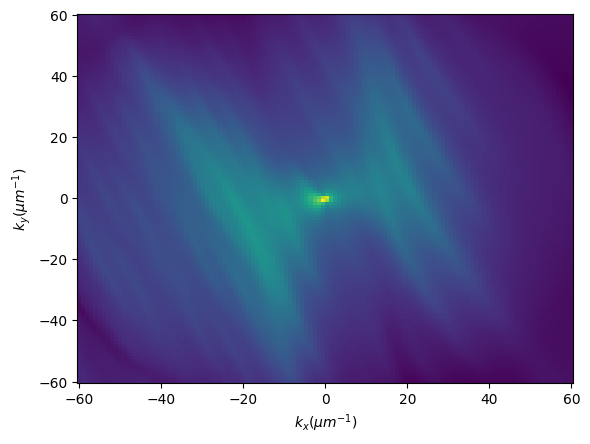

In [34]:
plt.figure(0)
plt.pcolor(kx,kx,np.abs(absr2)**(1/8))
plt.xlabel("$k_x (\mu m^{-1})$")
plt.ylabel("$k_y (\mu m^{-1})$")